# Minimal Example
This notebook demonstrates a 2-player dynamic game. Two players are trying to reach their goals, while avoiding each other and respecting their control limits.

In [7]:
using ALGAMES
using BenchmarkTools
using LinearAlgebra
using StaticArrays
using TrajectoryOptimization
const TO = TrajectoryOptimization;

### Define the dynamics model of the game.

In [8]:
struct DoubleIntegratorGame{T} <: AbstractGameModel
    n::Int  # Number of states
    m::Int  # Number of controls
    mp::T   # Mass of the point mass double integrator
    pu::Vector{Vector{Int}} # Indices of the each player's controls
    px::Vector{Vector{Int}} # Indices of the each player's x and y positions
    p::Int  # Number of players
end
DoubleIntegratorGame() = DoubleIntegratorGame(
    8,
    4,
    1.0,
    [[1,2],[3,4]],
    [[1,2],[5,6]],
    2)
Base.size(::DoubleIntegratorGame) = 8,4,[[1,2],[3,4]],2; # n,m,pu,p

### Instantiate dynamics model

In [9]:
model = DoubleIntegratorGame()
n,m,pu,p = size(model)
T = Float64
px = model.px

# We use the double integrator dynamics on a point mass in 2D. 
# State   x = [px1, py1, vx1, vy1, px2, py2, vx2, vy2] 
# Control u = [ax1, ay1, ax2, ay2]
# px1 = x position of player 1 
# vx1 = x velocity of player 1 
# ax1 = x acceleration of player 1 

function TO.dynamics(model::DoubleIntegratorGame, x, u) # Non memory allocating dynamics
    mp = model.mp  # mass of the point mass in kg (10)
    p = model.p  # number of players
    pu = model.pu  # control vector partition for each player
    q1 = x[ @SVector [1,2] ]
    qd1 = x[ @SVector [3,4] ]
    q2 = x[ @SVector [5,6] ]
    qd2 = x[ @SVector [7,8] ]
    control1 = @SVector [u[pu_ind] for pu_ind in pu[1]]
    control2 = @SVector [u[pu_ind] for pu_ind in pu[2]]
    qdd1 = control1/mp
    qdd2 = control2/mp
    return [qd1; qdd1; qd2; qdd2]
end

### Discretization of the trajectories

In [10]:
tf = 3.0  # final time
N = 41    # number of knot points
dt = tf / (N-1); # time step duration

### Initial and final state definition

In [11]:
# Define initial and final states (be sure to use Static Vectors!)
x0 = @SVector  [
               -0.50,  0.10,  0.50,  0.00, #player 1 x,y,vx,vy
               -0.50, -0.10,  0.40,  0.00, #player 2 x,y,vx,vy
                ]
xf = @SVector [
                0.50, -0.10,  0.40,  0.00, #player 1 x,y,vx,vy
                0.50,  0.10,  0.50,  0.80, #player 2 x,y,vx,vy
               ];

### Define players objective functions

In [12]:
# Define quadratic costs
diag_Q1 = @SVector [ # Player 1 state cost
    1., 1., 1., 1.,
    0., 0., 0., 0.]
diag_Q2 = @SVector [ # Player 2 state cost
    0., 0., 0., 0.,
    1., 1., 1., 1.]

# Players stage state costs
Q = [0.1*Diagonal(diag_Q1), 
     0.1*Diagonal(diag_Q2)]

# Players final state costs
Qf = [1.0*Diagonal(diag_Q1),
      1.0*Diagonal(diag_Q2)]

# Players controls costs
R = [0.1*Diagonal(@SVector ones(length(pu[1]))),
     0.1*Diagonal(@SVector ones(length(pu[2]))),
    ]

# Players objectives
obj = [LQRObjective(Q[i],R[i],Qf[i],xf,N) for i=1:p];

### Define the initial trajectory

In [13]:
xs = SVector{n}(zeros(n))
us = SVector{m}(zeros(m))
Z = [KnotPoint(xs,us,dt) for k = 1:N]
Z[end] = KnotPoint(xs,m);

### Build the actors

In [14]:
# Actors 
actor_radius = 0.08
actors_radii = [actor_radius for i=1:p]
actors_types = [:car, :car];

2-element Array{Symbol,1}:
 :car
 :car

### Define constraints of the problem

In [28]:
# Create constraint sets
conSet = ConstraintSet(n,m,N)
con_inds = 2:N # Indices where the constraints will be applied

# Add collision avoidance constraints
add_collision_avoidance(conSet, actors_radii, px, p, con_inds)

# Add bound constraints on the control inputs
u_min = - SVector{m}(ones(m))
u_max = + SVector{m}(ones(m))
con = BoundConstraint(n,m,u_min=u_min,u_max=u_max)
add_constraint!(conSet, con, con_inds)

### Define the problem we will be solving

In [29]:
prob = GameProblem(model, obj, conSet, x0, xf, Z, N, tf);

### Build the ALGAMES solver 

In [30]:
opts = DirectGamesSolverOptions{T}(
    iterations=10,
    inner_iterations=20,
    iterations_linesearch=10)
solver = DirectGamesSolver(prob, opts);

### Solve the problem

In [31]:
@time solve!(solver);

┌ Info: ("Solver iteration = ", 1)
└ @ ALGAMES /home/simon/research/repos/ALGAMES.jl/src/solvers/direct/direct_methods.jl:39
┌ Info: ("Solver iteration = ", 2)
└ @ ALGAMES /home/simon/research/repos/ALGAMES.jl/src/solvers/direct/direct_methods.jl:39


  3.480674 seconds (9.91 M allocations: 433.055 MiB, 3.76% gc time)


┌ Info: ("Solver iteration = ", 3)
└ @ ALGAMES /home/simon/research/repos/ALGAMES.jl/src/solvers/direct/direct_methods.jl:39
┌ Info: Outer loop converged: cost_tolerance & constraint_tolerance
└ @ ALGAMES /home/simon/research/repos/ALGAMES.jl/src/solvers/direct/direct_methods.jl:146


### Evaluate the solve time

In [32]:
opts = DirectGamesSolverOptions{T}(
    iterations=10,
    inner_iterations=20,
    iterations_linesearch=10,
    log_level=ALGAMES.Logging.Warn)
solver = DirectGamesSolver(prob, opts)
@btime timing_solve(solver);

  6.421 ms (8714 allocations: 4.53 MiB)


### Visualize state and control trajectories

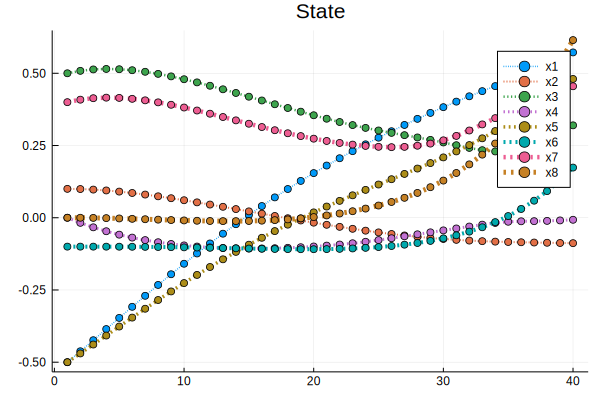

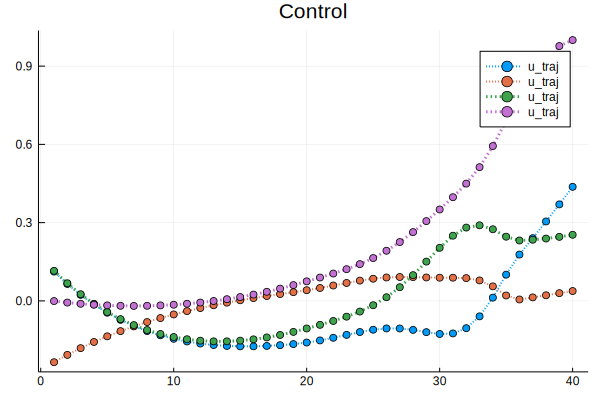

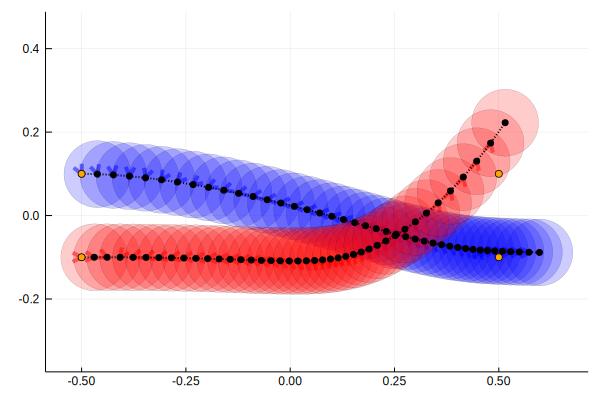

In [33]:
X = TO.states(solver)
U = TO.controls(solver)
visualize_state(X)
visualize_control(U,pu)
visualize_trajectory_car(solver)

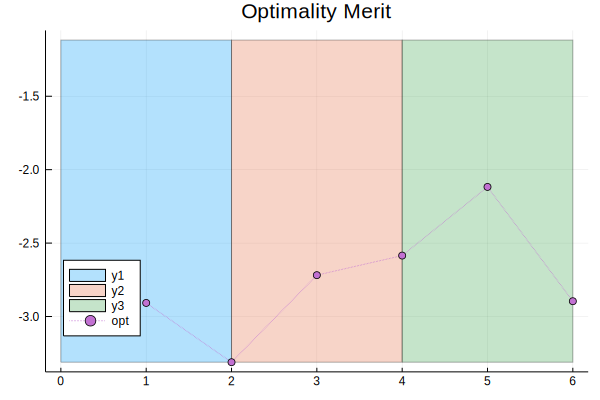

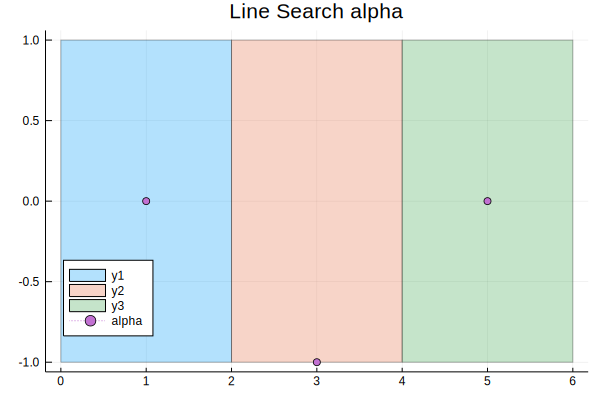

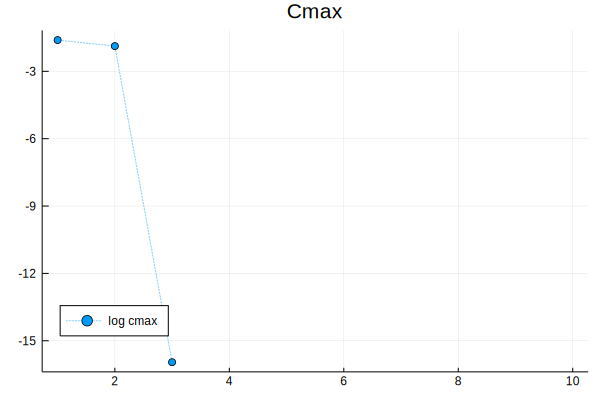

In [34]:
visualize_optimality_merit(solver)
visualize_α(solver)
visualize_cmax(solver)